In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.svm import SVR
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [8]:
df = pd.read_csv('N225.csv', parse_dates=['Date'], index_col='Date')

In [9]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-02-24,14803.639648,14982.530273,14658.139648,14837.679688,14837.679688,159500.0
2014-02-25,15002.509766,15094.540039,14957.490234,15051.599609,15051.599609,139500.0
2014-02-26,14896.490234,15084.530273,14896.490234,14970.969727,14970.969727,126600.0
2014-02-27,14939.870117,15015.009766,14844.370117,14923.110352,14923.110352,160300.0
2014-02-28,14929.549805,14943.650391,14735.519531,14841.070313,14841.070313,160500.0


In [17]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

In [18]:
df.head()

,Close
Date,
2014-02-24,14837.679688
2014-02-25,15051.599609
2014-02-26,14970.969727
2014-02-27,14923.110352
2014-02-28,14841.070313


In [20]:
df = df['2017-01-25' : ]
df[df==np.inf]=np.nan
df = df.dropna()

In [22]:
df = df.asfreq('D', method="Pad")

In [23]:
Y = df.values

In [24]:
Y.size

758

In [25]:
X = np.array(range(758)).reshape(-1, 1)
X.shape

(758, 1)

In [35]:
svr = SVR(kernel='rbf', C=10000, gamma=0.1)

In [36]:
svr.fit(X[:730], Y[:730])

/home/umang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=10000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

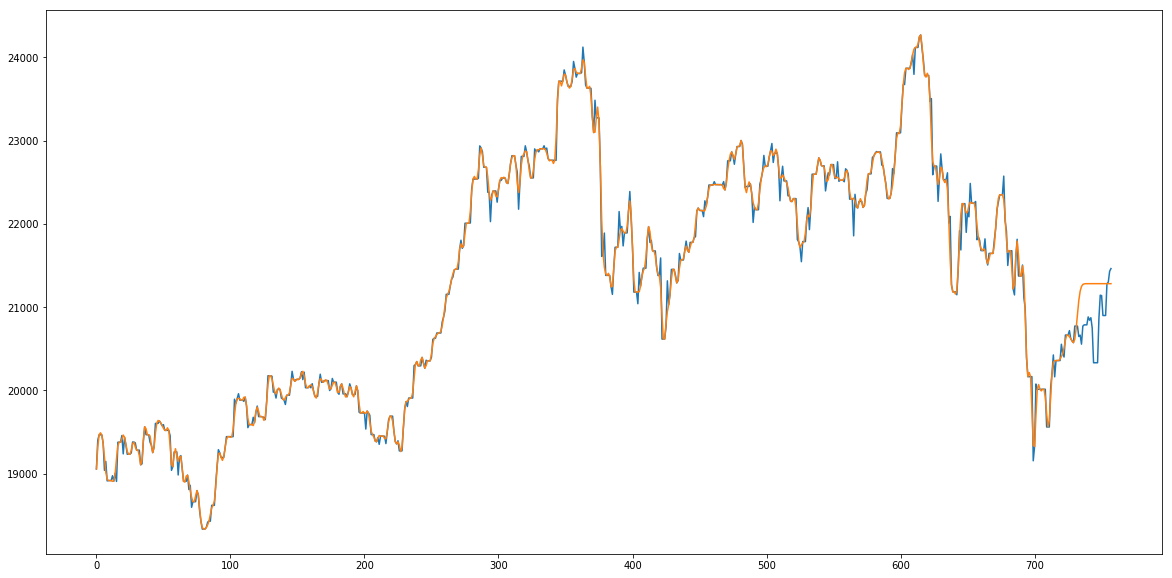

In [37]:
plt.plot(Y)
plt.plot(svr.predict(X))

In [38]:
rms=np.sqrt(np.mean(np.power((Y[530:]-svr.predict(X[530:])),2)))
rms

1560.2205055413938

In [39]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [56]:
df = pd.read_csv('N225.csv', parse_dates = ['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-02-24,14803.639648,14982.530273,14658.139648,14837.679688,14837.679688,159500.0
1,2014-02-25,15002.509766,15094.540039,14957.490234,15051.599609,15051.599609,139500.0
2,2014-02-26,14896.490234,15084.530273,14896.490234,14970.969727,14970.969727,126600.0
3,2014-02-27,14939.870117,15015.009766,14844.370117,14923.110352,14923.110352,160300.0
4,2014-02-28,14929.549805,14943.650391,14735.519531,14841.070313,14841.070313,160500.0


In [57]:
df = df.drop(['High', 'Open', 'Low', 'Volume', 'Adj Close'], axis = 1)

In [58]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [59]:
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [60]:
new_data[new_data==np.inf]=np.nan
new_data = new_data.dropna()
new_data.asfreq('D', method="pad")
new_data.head()

,Close
Date,
2014-02-24,14837.7
2014-02-25,15051.6
2014-02-26,14971
2014-02-27,14923.1
2014-02-28,14841.1


In [63]:
dataset = new_data.values

In [64]:
dataset.size

1227

In [65]:
train = dataset[:1000]
valid = dataset[1000:]

In [66]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

/home/umang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [67]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])


In [68]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [69]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [70]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))


In [71]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 56s - loss: 0.0041


In [72]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [73]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [74]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [75]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

479.46930779921394

/home/umang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/umang/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


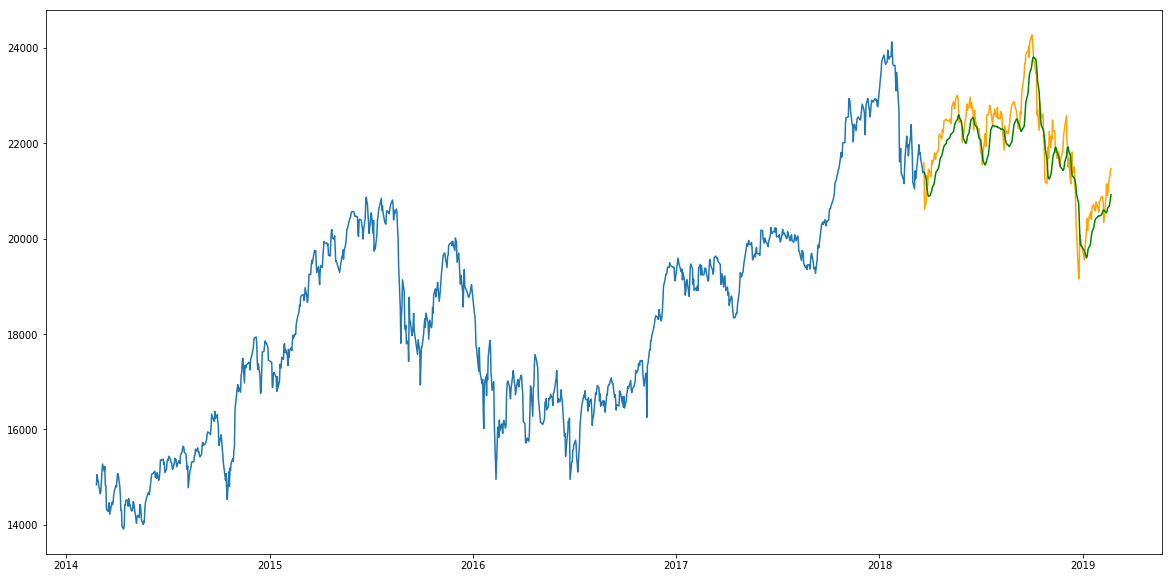

In [76]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
train = new_data[:1000]
valid = new_data[1000:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close']], color= 'orange')
plt.plot(valid[['Predictions']], color= 'green')